In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import geopy.distance

import category_encoders as ce

from sklearn import preprocessing
from sklearn.feature_selection import f_classif

from sklearn.ensemble import RandomForestRegressor  
from sklearn import metrics

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
# инструменты для лингвистического анализа:
import nltk  
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer  
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\79265\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# фиксация RANDOM_SEED для воспроизводимости экспериментов
RANDOM_SEED = 42

In [4]:
# фиксация версии пакетов для воспроизводимости экспериментов
!pip freeze > requirements.txt

## Загрузка данных для выполнения заданий из юнита 4 модуля "PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle"

In [5]:
df = pd.read_csv('data/hotels.csv')
df.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

### 4.1 Дополнить списки num_cols и cat_cols для оценки значимости всех признаков

In [7]:
num_cols = list(df.select_dtypes(['int64','float64']).columns)
num_cols

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng']

In [8]:
cat_cols = list(df.select_dtypes('object').columns)
cat_cols

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

### 4.2 Сколько отелей представлено в наборе данных?

In [9]:
df['hotel_name'].nunique()

1492

### 4.3 Даты размещения отзывов

In [10]:
# преобразование типа признака 'review_date' к формату datetime
df['review_date'] = pd.to_datetime(df['review_date'], dayfirst=False)

# Самый свежий отзыв оставлен:
print(df['review_date'].max())
print()

# Самый первый отзыв оставлен:
print(df['review_date'].min())

2017-08-03 00:00:00

2015-08-04 00:00:00


### 4.4 Сколько уникальных тегов представлено в наборе данных?

In [11]:
# Дано ментором как пример. На основании данной информации дальше напиcала свою функцию
# def rev_func(num_tags):
#     num_tags = num_tags[2:-2]
#     res = num_tags.strip().split(' \', \' ')
#     return res

# df['tags_n'] = df['tags'].apply(rev_func)

# df = df.explode('tags_n')
# len(df['tags_n'].unique())

In [12]:
def get_unique_tags(tags):
    unique_tags = []
    for tag_list in tags:
        for tag in tag_list[2:-2].split('\', \''):
            if tag.strip() not in unique_tags:
                unique_tags.append(tag.strip())
    print(f'Число уникальных тегов: {len(unique_tags)}')
    return

In [13]:
unique_tags = get_unique_tags(df['tags'])
unique_tags

Число уникальных тегов: 2368


### 4.5 Какой тег представлен в наибольшем числе отзывов?

In [14]:
tags = []
for tag_list in df['tags']:
    for tag in tag_list[2:-2].split('\', \''):
        tags.append(tag.strip())

cnt = Counter(tags)
list(cnt.most_common()[0])[0]

'Leisure trip'

### 4.6 Выяснить из тегов, на сколько ночей чаще всего останавливаются путешественники в отелях.

In [15]:
for i in cnt.most_common():
    tag = i[0]
    cnt = i[1]
    if ' night' in i[0]:
        print(f'{tag}: {cnt}')

Stayed 1 night: 145373
Stayed 2 nights: 100263
Stayed 3 nights: 72000
Stayed 4 nights: 35748
Stayed 5 nights: 15611
Stayed 6 nights: 7399
Stayed 7 nights: 5549
Stayed 8 nights: 1910
Stayed 9 nights: 966
Stayed 10 nights: 663
Stayed 11 nights: 306
Stayed 12 nights: 217
Stayed 14 nights: 184
Stayed 13 nights: 174
Stayed 15 nights: 87
Stayed 16 nights: 38
Stayed 17 nights: 27
Stayed 18 nights: 24
Stayed 19 nights: 23
Stayed 21 nights: 19
Stayed 20 nights: 17
Stayed 27 nights: 10
Stayed 30 nights: 10
Stayed 22 nights: 8
Stayed 28 nights: 7
Stayed 26 nights: 6
Special Offer Double Room 3 nights minimum: 6
Stayed 23 nights: 6
Stayed 24 nights: 5
Junior Suite Give me the night: 4
Stayed 25 nights: 4
Stayed 29 nights: 3


### 4.7 значение метрики MAPE на этом этапе

In [16]:
# убираем категориальные признаки и признак даты
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)
df.drop('review_date', axis = 1, inplace=True)

# заполняем пропуски нулями
df = df.fillna(0)

In [17]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = df.drop(['reviewer_score'], axis = 1)  
y = df['reviewer_score']

In [18]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [20]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1413910658348179


## Загрузка данных для соревнования на Kaggle

In [21]:
train_data = pd.read_csv('data/hotels_train.csv')
train_data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [22]:
test_data = pd.read_csv('data/hotels_test.csv')
test_data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


In [23]:
submission = pd.read_csv('data/submission.csv')
submission.head(3)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


In [24]:
print(f'Размер тренировочной выборки: {train_data.shape}.\
    \nРазмер тестовой выборки: {test_data.shape}.\
        \nРазмер сабмита: {submission.shape}.')

Размер тренировочной выборки: (386803, 17).    
Размер тестовой выборки: (128935, 16).        
Размер сабмита: (128935, 2).


In [25]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
train_data['sample'] = 1 # помечаем трейн
test_data['sample'] = 0 # помечаем тест
test_data['reviewer_score'] = 0 # в тесте нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test_data.append(train_data, sort=False).reset_index(drop=True) # объединяем

C:\Users\79265\AppData\Local\Temp\ipykernel_1300\93398174.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = test_data.append(train_data, sort=False).reset_index(drop=True) # объединяем


In [26]:
# основная информация о данных, кол-вах пропусков, типах данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Создание признаков

In [27]:
# в целях избежания ошибок на каждом этапе будем проводить сверку размерности таблицы
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 18)


### Работа с признаком адреса

In [28]:
# в целях создания признаков страны и города смотрим написание адресов
data.iloc[0:20]['hotel_address'].values

array(['Via Senigallia 6 20161 Milan Italy',
       'Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands',
       'Mallorca 251 Eixample 08008 Barcelona Spain',
       'Piazza Della Repubblica 17 Central Station 20124 Milan Italy',
       'Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands',
       'Coram Street Camden London WC1N 1HT United Kingdom',
       'Empire Way Wembley Brent London HA9 8DS United Kingdom',
       '1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom',
       '35 Rue Caumartin 9th arr 75009 Paris France',
       '49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom',
       'Via Giorgio Stephenson 55 20157 Milan Italy',
       'Spaarndammerdijk 304 Westerpark 1013 ZX Amsterdam Netherlands',
       'Damrak 1 5 Amsterdam City Center 1012 LG Amsterdam Netherlands',
       'Caspe 103 Eixample 08013 Barcelona Spain',
       'Via Napo Torriani 24 Central Station 20124 Milan Italy',
       'Oudeschans 75 Amste

In [29]:
# Если страна - UK, написание адреса отличается, при чем количество элементов в строке - разное.

# функция создания признака страны из признака адреса
def get_country(address):
    #разделяем строку на слова, создаем список слов
    address_list = address.split(' ')
    # проверка, является ли страна UK
    if address_list[-1] == 'Kingdom':
        country = 'United Kingdom' # если да, прописываем название
    else:
        country = address_list[-1] # если нет, оставляем последний элемент

    return country

In [30]:
# функция создания признака города из признака адреса
def get_city(address):
    #разделяем строку на слова, создаем список слов
    address_list = address.split(' ')
    # проверка, является ли страна UK
    if address_list[-1] == 'Kingdom':
        city = address_list[-5] # если да, обрезаем список, оставляя 5й элемент с конца - Лондон
    else:
        city = address_list[-2] #если нет, обрезаем список, оставляя предпоследний элемент - город
    
    return city

In [31]:
# признак страны
data['country'] = data['hotel_address'].apply(get_country)

# признак города
data['city'] = data['hotel_address'].apply(get_city)

In [32]:
# анализ созданных признаков: уникальные значения, их количество
print(data['country'].unique().tolist(), data['country'].nunique(), sep='\n')

['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France', 'Austria']
6


In [33]:
print(data['city'].unique().tolist(), data['city'].nunique(), sep='\n')

['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna']
6


In [34]:
# удаление признака адреса
data.drop('hotel_address', axis=1, inplace=True)

In [35]:
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 19)


### Работа с признаками географических координат

In [36]:
# из вывода общей информации выше знаем, что пропуски есть только в признаках с координатами. их доля:
data[['lat', 'lng']].isnull().mean() * 100

lat    0.633655
lng    0.633655
dtype: float64

In [37]:
# учитывая незначительную долю пропусков (менее 1%), заполним их константами для последующего создания признака 
# удаленности отеля от центра города

# создаем словари для замены константами (данные с сайта https://anyroad.ru/city/coordinates)
values_lat = {
    'London': 51.5073500, 
    'Barcelona': 41.3850600,
    'Paris': 48.8534100,
    'Amsterdam': 52.3702200,
    'Vienna': 48.2081700,
    'Milan': 45.4654200  
}

values_lng = {
    'London': -0.1277600, 
    'Barcelona': 2.173400,
    'Paris': 2.3488000,
    'Amsterdam': 4.8951700,
    'Vienna': 16.3738200,
    'Milan': 9.1859200  
}

#заполняем пропуски в соответствии с заявленным словарем
data['lat'] = data[['city','lat']].apply(lambda x: values_lat[x.city] if np.isnan(x.lat) else x.lat, axis=1)
data['lng'] = data[['city','lng']].apply(lambda x: values_lng[x.city] if np.isnan(x.lng) else x.lng, axis=1)

In [38]:
# результирующая доля пропусков
data[['lat', 'lng']].isnull().mean() * 100

lat    0.0
lng    0.0
dtype: float64

In [39]:
# данные с координатами центров горoдов (с сайта https://dateandtime.info/)
centers = pd.DataFrame(
    data = [
        ['United Kingdom', 'London', 51.5085300, -0.1257400],
        ['France', 'Paris', 48.8534100, 2.3488000],
        ['Spain', 'Barcelona', 41.3887900, 2.1589900],
        ['Italy', 'Milan', 45.4642700, 9.1895100],
        ['Austria', 'Vienna', 48.2084900, 16.3720800],
        ['Netherlands', 'Amsterdam', 52.3740300, 4.8896900],
    ],
    columns= ['country', 'city', 'center_lat', 'center_lng']
).set_index('country')

In [40]:
# функция вычисления расстояния между отелем и центром города
def get_dist_to_center(country, lng, lat):
    center_lat = centers['center_lat'][country]  
    center_lng = centers['center_lng'][country]

    return geopy.distance.geodesic([center_lng, center_lat], [lng, lat]).km

In [41]:
# признак удаленности отеля от центра города
data['distance_to_center'] = data[['hotel_name', 'country', 'lng', 'lat']].apply(
    lambda row: get_dist_to_center(row['country'], row['lng'], row['lat']), axis=1
    )

In [42]:
# удаление столбцов с координатами
data.drop(['lng', 'lat'], axis=1, inplace=True) 

In [43]:
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 18)


### Работа с признаком даты

In [44]:
# преобразование типа признака даты в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=False)

In [45]:
# создание признака месяца
data['month'] = data['review_date'].dt.month

In [46]:
# поиск "высокого сезона"
data['month'].value_counts().nlargest(5)

8     50672
7     49318
5     46490
10    43843
6     42896
Name: month, dtype: int64

In [47]:
# к "высокому сезону" отнесем 8й, 7й, 5й месяцы (между 3м "местом" и 4м заметный разрыв)
# создадим признак-мигалку, относится ли день написания отзыва к "высокому сезону"
data['high_season'] = data['month'].apply(lambda x: 1 if x in [5, 7, 8] else 0)

In [48]:
# функция определения сезона, когда создан отзыв
def get_season(month):
    if month in [1, 2, 12]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4

In [49]:
# создание признака сезона
data['season'] = data['month'].apply(get_season)

In [50]:
day_of_week = data['review_date'].dt.dayofweek

In [51]:
# функция определения, был ли день, когда оставили отзыв, выходным
def get_day_of_week(weekday):
    if weekday == 5 or weekday == 6:
        return 1
    else:
        return 0

In [52]:
# признак - мигалка, был ли день, когла оставили отзыв, выходным
data['weekend'] = day_of_week.apply(get_day_of_week)

In [53]:
# удаление признака даты
data.drop('review_date', axis=1, inplace=True) 

In [54]:
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 21)


### Работа с признаком страны рецензента

In [55]:
# удаление начальных и конечных символов
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

In [56]:
# количество стран, из которых едут туристы
data["reviewer_nationality"].nunique()

227

In [57]:
# слишком много. выведем 25 наиболее популярных
data["reviewer_nationality"].value_counts().nlargest(25)

United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
Saudi Arabia                  8951
Netherlands                   8772
Switzerland                   8678
Germany                       7941
Canada                        7894
France                        7296
Israel                        6610
Italy                         6114
Belgium                       6031
Turkey                        5444
Kuwait                        4920
Spain                         4737
Romania                       4552
Russia                        3900
South Africa                  3821
India                         3437
Greece                        3406
China                         3400
Sweden                        3368
New Zealand                   3237
Name: reviewer_nationality, dtype: int64

In [58]:
# анализ 25 наиболее популярных - непоказателен. 
# возьмем первые 20 (после не такие большие разрывы), остальные - "other":
popular_nations = list(data['reviewer_nationality'].value_counts()[:20].index)
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in popular_nations else 'other')

In [59]:
# признак страны рецензента пока удалять не будем для дальнейшего его кодирования

print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 21)


### Работа с признаком негативных отзывов

In [60]:
# приведем строки в признаке к единообразию
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip().lower())
# выведем 50 самых популярных отзывов (1я половина)
data['negative_review'].value_counts().nlargest(50).head(25)

no negative                  127890
nothing                       21185
n a                            1815
none                           1501
                                849
nothing really                  656
small room                      570
all good                        545
breakfast                       545
no complaints                   523
location                        502
nothing at all                  467
everything                      420
nothing to dislike              373
price                           348
nil                             332
small rooms                     307
everything was perfect          276
na                              272
can t think of anything         250
leaving                         244
absolutely nothing              242
everything was great            222
expensive                       206
nothing to complain about       205
Name: negative_review, dtype: int64

In [61]:
# выведем 50 самых популярных отзывов (2я половина)
data['negative_review'].value_counts().nlargest(50).tail(25)

no                                200
very small room                   200
room size                         200
nothing not to like               185
nothing all good                  181
staff                             181
having to leave                   176
not much                          159
i liked everything                153
everything was good               153
liked everything                  148
see above                         141
expensive breakfast               138
nothing it was perfect            136
non                               134
nothing everything was perfect    133
the price                         132
room too small                    127
room was very small               126
nothing in particular             121
everything was fine               120
nothing everything was great      120
not applicable                    115
all was good                      114
wifi                              112
Name: negative_review, dtype: int64

In [62]:
# в признаке есть "ложноотрицательные" отзывы. создадим из них список 
# (из тех, которые встречаются более 150 раз, остальное - незначительно)
no_negative_review = ['no negative', 'nothing', 'n a', 'none', '', ' ', 'all good', 'no complaints', 'everything was perfect', \
    'na', 'everything was great', 'nothing to complain about', 'no', 'i liked everything', 'everything was good']

# создадим признак того, является ли отзыв отрицательным
data['is_negative'] = data['negative_review'].apply(lambda x: 0 if x in no_negative_review else 1)

In [63]:
data['is_negative'].mean()

0.6979299566834323

In [64]:
# на данном этапе признак оставим для дальнейшей обработки с помощью SentimentIntensityAnalyzer библиотеки VADER

print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 22)


### Работа с признаком положительных отзывов

In [65]:
# приведем строки в признаки к единообразию
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip().lower())
# выведем 50 самых популярных отзывов (1я половина)
data['positive_review'].value_counts().nlargest(50).head(25)

no positive                   35946
location                      11945
everything                     3314
nothing                        1731
great location                 1687
the location                   1606
good location                  1496
breakfast                       795
friendly staff                  733
excellent location              639
staff                           553
location and staff              452
location staff                  432
location location location      345
location was great              328
good breakfast                  316
everything was perfect          316
location was good               312
comfy bed                       303
perfect location                287
the staff                       281
location is great               280
location is good                256
all                             250
clean                           237
Name: positive_review, dtype: int64

In [66]:
# выведем 50 самых популярных отзывов (2я половина)
data['positive_review'].value_counts().nlargest(50).tail(25)

every thing                      235
very friendly staff              233
great breakfast                  222
breakfast was good               220
excellent breakfast              218
location was excellent           205
comfortable bed                  202
very good location               198
cleanliness                      193
location breakfast               188
                                 183
location is perfect              175
helpful staff                    172
great location friendly staff    172
location only                    168
great staff                      167
everything was great             163
location is excellent            163
central location                 157
staff and location               156
friendly helpful staff           156
the bed                          155
convenient location              151
position                         149
location and breakfast           148
Name: positive_review, dtype: int64

In [67]:
# в признаке есть "ложноположительные" отзывы. создадим из них список 
no_positive_review = ['no positive', 'nothing', '', ' ']

# создадим признак того, является ли отзыв положительным
data['is_positive'] = data['positive_review'].apply(lambda x: 0 if x in no_positive_review else 1)

In [68]:
data['is_positive'].mean()

0.9265906332284998

In [69]:
# на данном этапе признак оставим для дальнейшей обработки с помощью SentimentIntensityAnalyzer библиотеки VADER

print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 23)


### Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER

In [70]:
# реализация анализа взята у Eco 189 https://www.kaggle.com/code/eco189/project-3-1/notebook?scriptVersionId=105582270

# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

In [71]:
# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований:')
print(sia_neg.polarity_scores(example), '\n')

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 



In [72]:
# добавим контекст:
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

print(f' - после преобразований (для негативного контекста):')
print(sia_neg.polarity_scores(example))
print(f' - после преобразований (для позитивного контекста):')
print(sia_pos.polarity_scores(example))

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}


In [73]:
# фразы "No Negative" тонально будет нести негативную окраску:
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}":')
print(sia_neg.polarity_scores(example))
example = 'Positive'
print(f'Словарь оценок фразы "{example}":')
print(sia_neg.polarity_scores(example))


Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [74]:
# меняем метки отсутствия частей отзыва:
data['negative_review_temp'] = data['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
data['positive_review_temp'] = data['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

In [75]:
data['negative_review_sentiments'] = data['negative_review_temp'].apply(lambda x: sia_neg.polarity_scores(x))
data['positive_review_sentiments'] = data['positive_review_temp'].apply(lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
data['n_review_sentiments_neg'] = data['negative_review_sentiments'].apply(lambda x: x['neg'])
data['n_review_sentiments_neu'] = data['negative_review_sentiments'].apply(lambda x: x['neu'])
data['n_review_sentiments_pos'] = data['negative_review_sentiments'].apply(lambda x: x['pos'])
data['n_review_sentiments_compound'] = data['negative_review_sentiments'].apply(lambda x: x['compound'])

data['p_review_sentiments_neg'] = data['positive_review_sentiments'].apply(lambda x: x['neg'])
data['p_review_sentiments_neu'] = data['positive_review_sentiments'].apply(lambda x: x['neu'])
data['p_review_sentiments_pos'] = data['positive_review_sentiments'].apply(lambda x: x['pos'])
data['p_review_sentiments_compound'] = data['positive_review_sentiments'].apply(lambda x: x['compound'])

In [76]:
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 35)


In [77]:
# удaление столбцов 
cols_to_delete = ['negative_review', 'negative_review_temp','negative_review_sentiments',
                  'positive_review', 'positive_review_temp', 'positive_review_sentiments']
data.drop(cols_to_delete, axis=1, inplace=True) 

In [78]:
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 29)


### Работа с признаком тэгов

In [79]:
# очистка признака тэгов от лишних символов, переход к спискам
def rev_func(tags):
    tags = tags[2:-2].strip().split(' \', \' ')
    return tags

data['formatted_tags'] = data['tags'].apply(rev_func)

In [80]:
# анализ тэгов
# 40 самых популярных. первая половина
tags_list = []
for x in data['formatted_tags']:
    for tag in x:
        tags_list.append(tag)
        
tags_count = Counter(tags_list)
tags_count.most_common(40)[:20]

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015),
 ('Stayed 4 nights', 47817),
 ('Double Room', 35207),
 ('Standard Double Room', 32248),
 ('Superior Double Room', 31393),
 ('Family with older children', 26349),
 ('Deluxe Double Room', 24823),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20845),
 ('Standard Double or Twin Room', 17483),
 ('Classic Double Room', 16989)]

In [81]:
# 40 самых популярных. вторая половина
tags_count.most_common(40)[20:]

[('Superior Double or Twin Room', 13570),
 ('2 rooms', 12393),
 ('Stayed 6 nights', 9776),
 ('Standard Twin Room', 9745),
 ('Single Room', 9670),
 ('Twin Room', 8321),
 ('Stayed 7 nights', 7399),
 ('Executive Double Room', 6425),
 ('Classic Double or Twin Room', 6107),
 ('Superior Twin Room', 6064),
 ('Deluxe Double or Twin Room', 5998),
 ('Club Double Room', 5908),
 ('Queen Room', 5472),
 ('Deluxe King Room', 5357),
 ('Superior Queen Room', 4898),
 ('Standard Single Room', 4615),
 ('Junior Suite', 4559),
 ('Triple Room', 4493),
 ('Superior Room', 4417),
 ('Classic Room', 4416)]

In [82]:
# списки выявленных категорий
status_trip = ['Leisure trip', 'Business trip']

status_group = ['Couple','Family with older children',
                'Family with young children','Group', 
                'Solo traveler', 'Travelers with friends', 
                'With a pet'] 

rooms = ['Single Room', 
        'Double Room', 'Double or Twin Room', '2 rooms', 'Twin Room',
        'Triple Room']

In [83]:
# функция определения цели поездки - досуг/бизнес
def trip_status(tag):
    if status_trip[0] in tag:
        return 1
    elif status_trip[1] in tag:
        return 2
    else: 
        return 0

In [84]:
# создание признака цели поездки             
data['trip_status'] = data['formatted_tags'].apply(trip_status)

In [85]:
# проверка корректности работы функции
data['trip_status'].value_counts()

1    417778
2     82939
0     15021
Name: trip_status, dtype: int64

In [86]:
# функция определения типа группы путешествующих
def group_status(tag):
    if status_group[0] in tag:
        return 1
    elif status_group[1] in tag:
        return 2
    elif status_group[2] in tag:
        return 3
    elif status_group[3] in tag:
        return 4
    elif status_group[4] in tag:
        return 5
    elif status_group[5] in tag:
        return 6
    elif status_group[6] in tag:
        return 7
    else:
        return 0 

In [87]:
# создание признака типа группы            
data['group_status'] = data['formatted_tags'].apply(group_status)

In [88]:
# проверка корректности работы функции
data['group_status'].value_counts()

1    252294
5    108545
4     65392
3     61015
2     26349
6      2143
Name: group_status, dtype: int64

In [89]:
# функция определения количества ночей
def get_nights(tag):
    for elem in tag:
        if 'night' in elem:
            for i in elem.split():
                if i.isdigit():
                    return i

In [90]:
# создание признака количества ночей, проведенных в отелей
data['nights_in_hotel'] = data['formatted_tags'].apply(get_nights)

In [91]:
# проверка корректности работы функции
data['nights_in_hotel'].value_counts().nlargest(10)

1     193644
2     133936
3      95825
4      47817
5      20843
6       9776
7       7399
8       2502
9       1293
10       889
Name: nights_in_hotel, dtype: int64

In [92]:
# функция определения количества комнат в номере
def number_of_rooms(tag):
    if rooms[0] in tag:
        return 1
    # сделаем допущение, что если путешествует один человек, то он остановливается в однокомнатном номере
    elif 'Solo traveler' in tag:
        return 1
    elif rooms[1] in tag or rooms[2] in tag or rooms[3] in tag or rooms[4] in tag:
        return 2
    elif rooms[5] in tag:
        return 3 
    else: 
        return 0

In [93]:
# создание признака количества комнат в номере (из неотформатированного признака тэгов в целях поиска словосочетаний в строке)
data['rooms'] = data['tags'].apply(number_of_rooms)

In [94]:
# проверка корректности работы функции
data['rooms'].value_counts()

2    277528
0    118051
1    111301
3      8858
Name: rooms, dtype: int64

In [95]:
# создание признака использования мобильного телефона при отправке отзывов
data['is_mobile'] = data['formatted_tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

In [96]:
# проверка корректности работы функции
data['is_mobile'].value_counts()

1    307640
0    208098
Name: is_mobile, dtype: int64

In [97]:
# проверка новых признаков
data[['formatted_tags', 'trip_status', 'group_status', 'nights_in_hotel', 'rooms', 'is_mobile']].head(15)

,formatted_tags,trip_status,group_status,nights_in_hotel,rooms,is_mobile
0,"[Leisure trip, Couple, Double Room, Stayed 2 n...",1,1,2,2,0
1,"[Leisure trip, Group, Triple Room, Stayed 1 ni...",1,4,1,3,0
2,"[Business trip, Solo traveler, Twin Room, Stay...",2,5,1,1,1
3,"[Leisure trip, Couple, Ambassador Junior Suite...",1,1,1,0,0
4,"[Business trip, Solo traveler, Classic Double ...",2,5,2,1,1
5,"[Business trip, Solo traveler, Standard Double...",2,5,1,1,0
6,"[Leisure trip, Couple, Queen Room, Stayed 1 ni...",1,1,1,0,0
7,"[Business trip, Solo traveler, Executive Room,...",2,5,3,1,1
8,"[Group, Double or Twin Room, Stayed 1 night]",0,4,1,2,0
9,"[Couple, Standard Triple Room, Stayed 2 nights...",0,1,2,3,1


In [98]:
# удаление признаков тэгов (исходных и форматированных)
data.drop(['formatted_tags', 'tags'], axis=1, inplace=True)

In [99]:
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 33)


### Визуализация взаимосвязи средней оценки и различных признаков

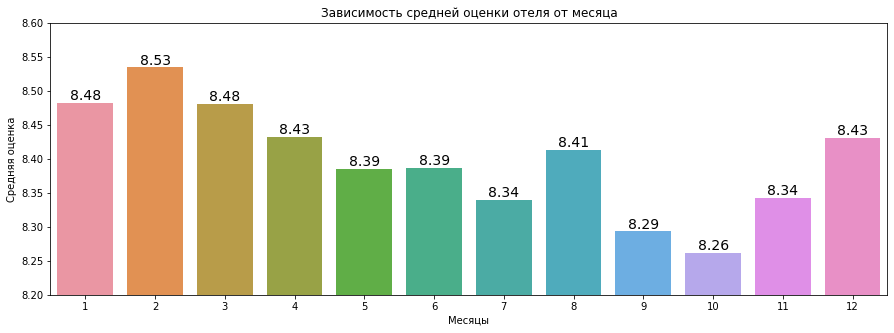

In [100]:
# визуализация зависимости средней оценки отеля от месяца (по данным из изначально тренировочного датасета)
pivot_month = data[data['sample'] == 1][['month', 'reviewer_score']].groupby('month', as_index=False).mean()

fig = plt.figure(figsize=(15, 5))
barplot1 = sns.barplot(
    data=pivot_month,
    x='month',
    y='reviewer_score'
)
barplot1.set_title('Зависимость средней оценки отеля от месяца')
barplot1.set_xlabel('Месяцы')
barplot1.set_ylabel('Средняя оценка')

for p in barplot1.patches:
    barplot1.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8.2, 8.6);

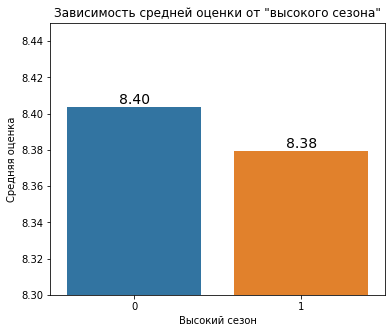

In [101]:
# визуализация зависимости средней оценки отеля от "высокого сезона" (по данным из изначально тренировочного датасета)
pivot_h_season = data[data['sample'] == 1][['high_season', 'reviewer_score']].groupby('high_season', as_index=False).mean()

fig = plt.figure(figsize=(6, 5))
barplot2 = sns.barplot(
    data=pivot_h_season,
    x='high_season',
    y='reviewer_score'
)
barplot2.set_title('Зависимость средней оценки от "высокого сезона"')
barplot2.set_xlabel('Высокий сезон')
barplot2.set_ylabel('Средняя оценка')

for p in barplot2.patches:
    barplot2.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8.3, 8.45);

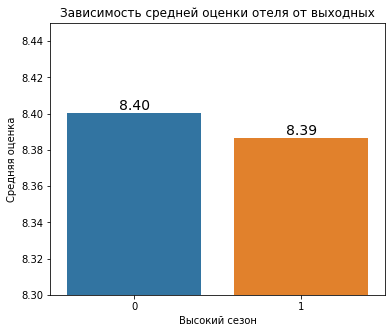

In [102]:
# визуализация зависимости средней оценки отеля от выходных (по данным из изначально тренировочного датасета)
pivot_weekend = data[data['sample'] == 1][['weekend', 'reviewer_score']].groupby('weekend', as_index=False).mean()

fig = plt.figure(figsize=(6, 5))
barplot3 = sns.barplot(
    data=pivot_weekend,
    x='weekend',
    y='reviewer_score'
)
barplot3.set_title('Зависимость средней оценки отеля от выходных')
barplot3.set_xlabel('Высокий сезон')
barplot3.set_ylabel('Средняя оценка')

for p in barplot3.patches:
    barplot3.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(8.3, 8.45);

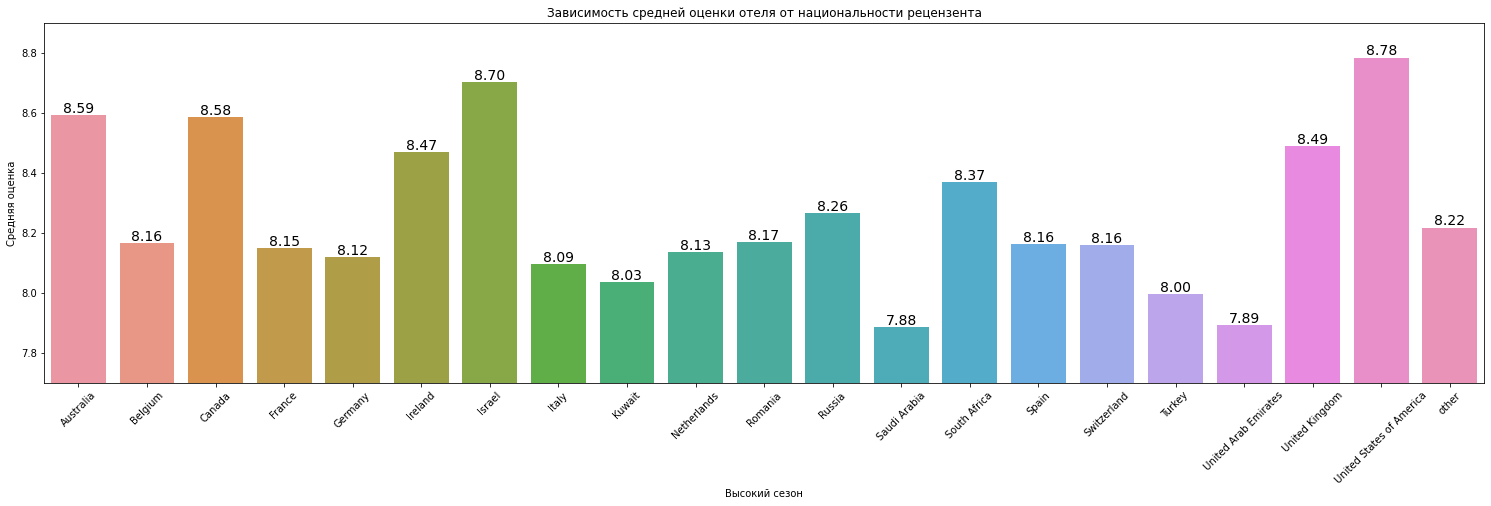

In [103]:
# визуализация зависимости средней оценки отеля от национальности рецензента (по данным из изначально тренировочного датасета)
pivot_natio = data[data['sample'] == 1][['reviewer_nationality', 'reviewer_score']].groupby('reviewer_nationality', as_index=False).mean()

fig = plt.figure(figsize=(20, 5))
ax = fig.add_axes([1, 1, 1, 1])

barplot4 = sns.barplot(
    data=pivot_natio,
    x='reviewer_nationality',
    y='reviewer_score'
)
barplot4.set_title('Зависимость средней оценки отеля от национальности рецензента')
barplot4.set_xlabel('Высокий сезон')
barplot4.set_ylabel('Средняя оценка')

ax.xaxis.set_tick_params(rotation = 45)

for p in barplot4.patches:
    barplot4.annotate(
        '{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
    ha='center', va='bottom', fontsize=14)

plt.ylim(7.7, 8.9);

## Кодирование признаков

In [104]:
print(f'Размерность таблицы до кодирования признаков: {data.shape}')

Размерность таблицы до кодирования признаков: (515738, 33)


In [105]:
# кодирование признаков методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['country', 'city', 'month', 'season']) 
type_bin = encoder.fit_transform(data[['country', 'city', 'month', 'season']])
data = pd.concat([data, type_bin], axis=1)

In [106]:
# кодирование признака национальности рецензента методом двоичного кодирования
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [107]:
# удаление преобразованных признаков
cols_to_delete_1 = ['country', 'city', 'month', 'season', 'reviewer_nationality']

data.drop(cols_to_delete_1, axis=1, inplace=True)

In [108]:
print(f'Размерность таблицы после кодирования признаков: {data.shape}')

Размерность таблицы после кодирования признаков: (515738, 61)


## Преобразование признаков

In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 61 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  object 
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [110]:
obj_cols = list(data.select_dtypes('object').columns)
num_cols = list(data.select_dtypes(['int64','float64']).columns)
num_cols.remove('sample')
num_cols.remove('reviewer_score')

In [111]:
len(num_cols)

56

In [112]:
data[num_cols].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,distance_to_center,high_season,weekend,is_negative,...,month_12,season_1,season_2,season_3,season_4,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,4.423649,0.284020,0.263339,0.697930,...,0.074398,0.277052,0.232924,0.237022,0.253002,0.065772,0.137597,0.202962,0.312909,0.819329
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.941234,0.450947,0.440445,0.459156,...,0.262418,0.447543,0.422695,0.425256,0.434733,0.247883,0.344477,0.402205,0.463678,0.384746
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,1.618990,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,3.150166,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,6.111753,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,27.214280,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [113]:
# признаки для нормализации
data_for_norm = data[num_cols]

data_for_norm.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,distance_to_center,high_season,weekend,is_negative,...,month_12,season_1,season_2,season_3,season_4,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
0,904,8.1,52,16670,62,1,7.837768,1,0,1,...,0,1,0,0,0,0,0,0,0,1
1,612,8.6,10,5018,0,7,6.243807,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,46,8.3,3,351,5,15,0.563942,0,0,1,...,0,0,0,1,0,0,0,0,1,1
3,241,9.1,0,1543,27,9,1.873428,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,834,9.1,0,4687,7,2,0.403517,1,0,0,...,0,0,0,0,1,0,0,0,0,1


In [114]:
# в связи со значительным количеством числовых признаков провести анализ на наличие в них выбросов не представляется возможным
# поэтому нормализовать признаки будем с помощью нормализатора RobustScaler

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
data_r = r_scaler.fit_transform(data_for_norm)

# преобразуем промежуточный датасет в полноценный датафрейм
data_r = pd.DataFrame(data_r, columns=num_cols)

In [115]:
data_r.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,distance_to_center,high_season,weekend,is_negative,...,month_12,season_1,season_2,season_3,season_4,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,0.319922,-0.003590,0.454260,0.248672,0.398615,0.595143,0.283452,0.284020,0.263339,-0.302070,...,0.074398,0.277052,0.232924,0.237022,0.253002,0.065772,0.137597,0.202962,0.312909,-0.180671
std,1.019427,0.782926,1.413849,0.945132,1.282599,1.577175,0.877241,0.450947,0.440445,0.459156,...,0.262418,0.447543,0.422695,0.425256,0.434733,0.247883,0.344477,0.402205,0.463678,0.384746
min,-0.692464,-4.571429,-0.428571,-0.852773,-0.647059,-0.285714,-0.701165,0.000000,0.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,-0.350305,-0.428571,-0.333333,-0.396819,-0.352941,-0.285714,-0.340809,0.000000,0.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.649695,0.571429,0.666667,0.603181,0.647059,0.714286,0.659191,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,4.767821,2.000000,19.000000,5.928222,22.588235,50.285714,5.356195,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [116]:
# удаляем из исходного датафрейма (data) признаки до нормализации и добавляем нормализированные признаки
data = data.drop(columns=num_cols)

data = pd.concat([data, data_r], axis=1)

data.head()

,hotel_name,days_since_review,sample,reviewer_score,nights_in_hotel,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,...,month_12,season_1,season_2,season_3,season_4,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
0,Hotel Da Vinci,13 days,0,0.0,2,1.146640,-0.428571,2.047619,5.928222,3.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Urban Lodge Hotel,234 day,0,0.0,1,0.551935,0.285714,0.047619,1.176183,-0.647059,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
2,Alexandra Barcelona A DoubleTree by Hilton,616 day,0,0.0,1,-0.600815,-0.142857,-0.285714,-0.727162,-0.352941,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Hotel Principe Di Savoia,656 day,0,0.0,1,-0.203666,1.000000,-0.428571,-0.241028,0.941176,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.0
4,Hotel Esther a,444 day,0,0.0,2,1.004073,1.000000,-0.428571,1.041191,-0.235294,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [117]:
print(f'Размерность таблицы после нормализации признаков: {data.shape}')

Размерность таблицы после нормализации признаков: (515738, 61)


## Отбор признаков

In [118]:
# удаление нечисловых признаков, т.к. на них модель все равно обучаться не будет
data.drop(obj_cols, axis=1, inplace=True)

In [119]:
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 58)


### Анализ мультиколлинеарности

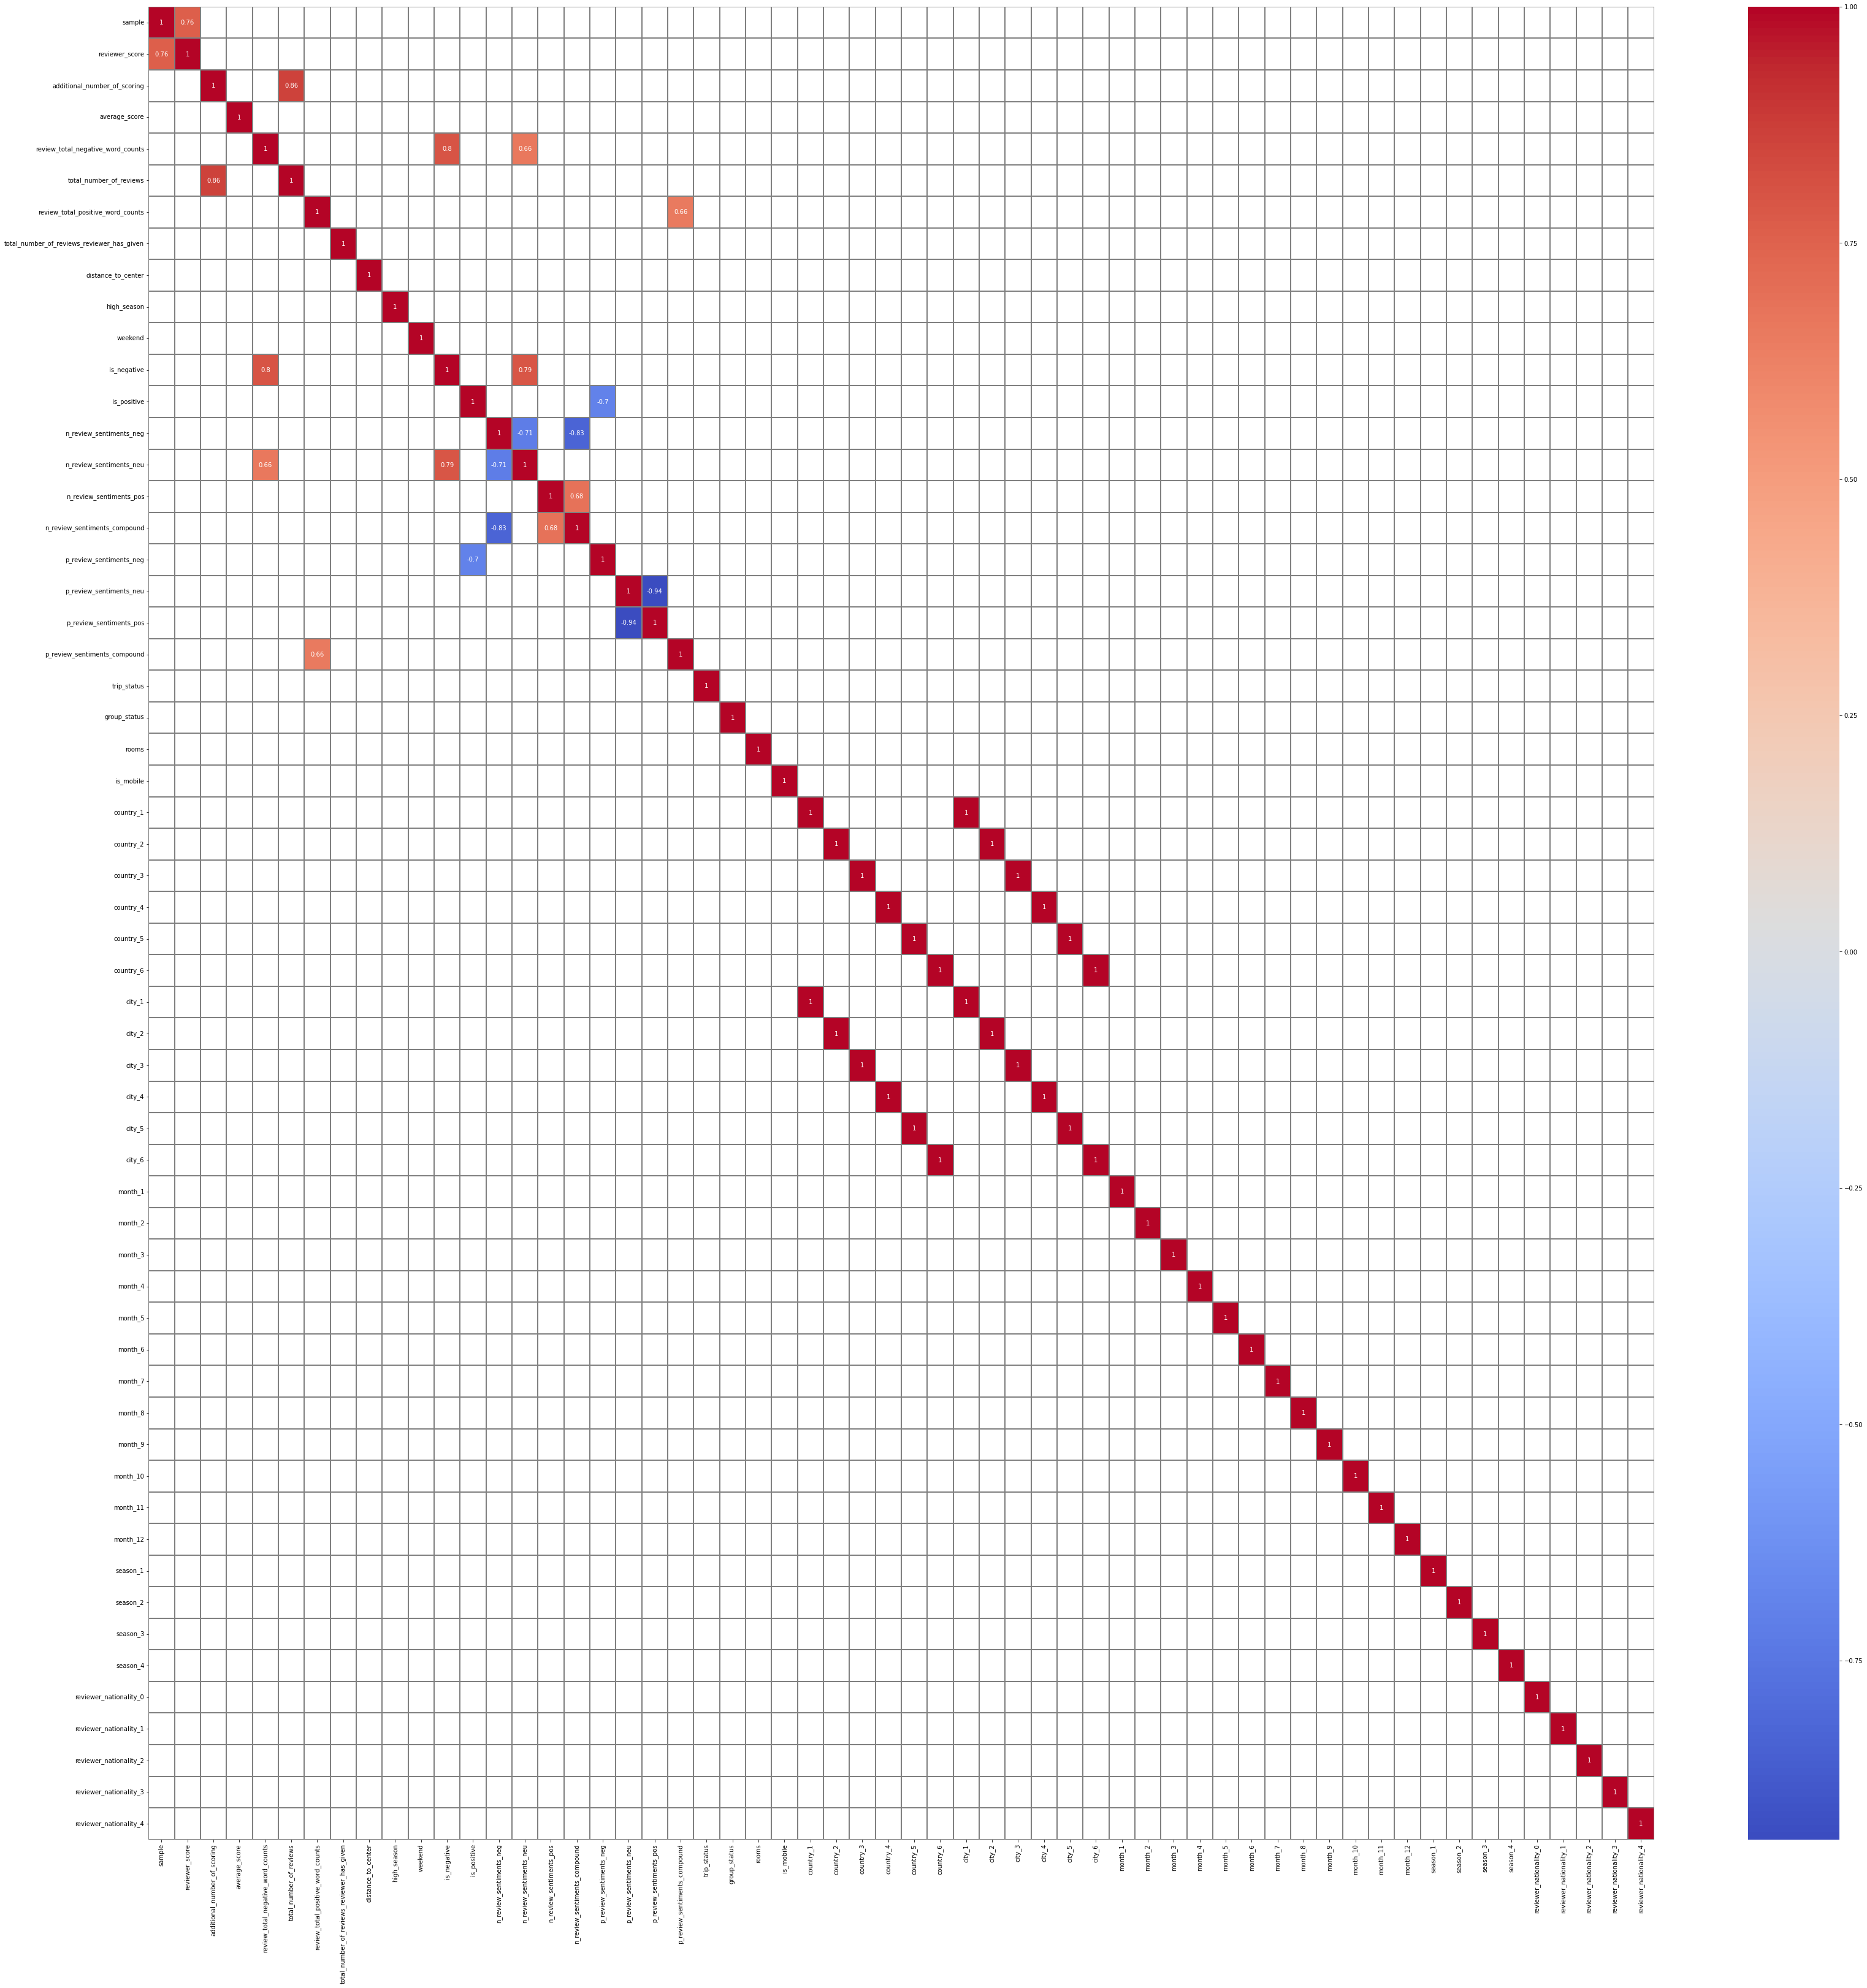

In [120]:
# в связи с тем, что оценка нормальности распределений не проводилась, для корреляции с непрерывными признаками 
# будем использовать метод Пирсона
corr = data.corr(method = 'spearman')

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.6
mask_2 = np.abs(corr) <= -0.6

corr_data = corr[mask_1 | mask_2]

# проверка признака на мультиколлинеарность
plt.rcParams['figure.figsize'] = (55,55)
sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidth=0.3, linecolor='gray');

In [121]:
# в связи с невозможностью детально проанализировать график, посмотрим корреляцию между признаками с помощью цикла
# рассмотрим признаки, между которыми наблюдается сильная связь
for row in corr_data.index:
    for col in corr_data.columns:
        if corr_data.loc[row, col] != 1 and abs(corr_data.loc[row, col]) >= 0.7:
            print(row, col, '-', round(abs(corr_data.loc[row, col]), 3))

sample reviewer_score - 0.759
reviewer_score sample - 0.759
additional_number_of_scoring total_number_of_reviews - 0.859
review_total_negative_word_counts is_negative - 0.797
total_number_of_reviews additional_number_of_scoring - 0.859
is_negative review_total_negative_word_counts - 0.797
is_negative n_review_sentiments_neu - 0.789
n_review_sentiments_neg n_review_sentiments_neu - 0.713
n_review_sentiments_neg n_review_sentiments_compound - 0.829
n_review_sentiments_neu is_negative - 0.789
n_review_sentiments_neu n_review_sentiments_neg - 0.713
n_review_sentiments_compound n_review_sentiments_neg - 0.829
p_review_sentiments_neu p_review_sentiments_pos - 0.939
p_review_sentiments_pos p_review_sentiments_neu - 0.939


In [122]:
# удалим признаки с сильной корреляцией
data.drop(['additional_number_of_scoring', 'review_total_negative_word_counts'], axis=1, inplace=True)

In [123]:
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 56)


### Оценка значимости признаков

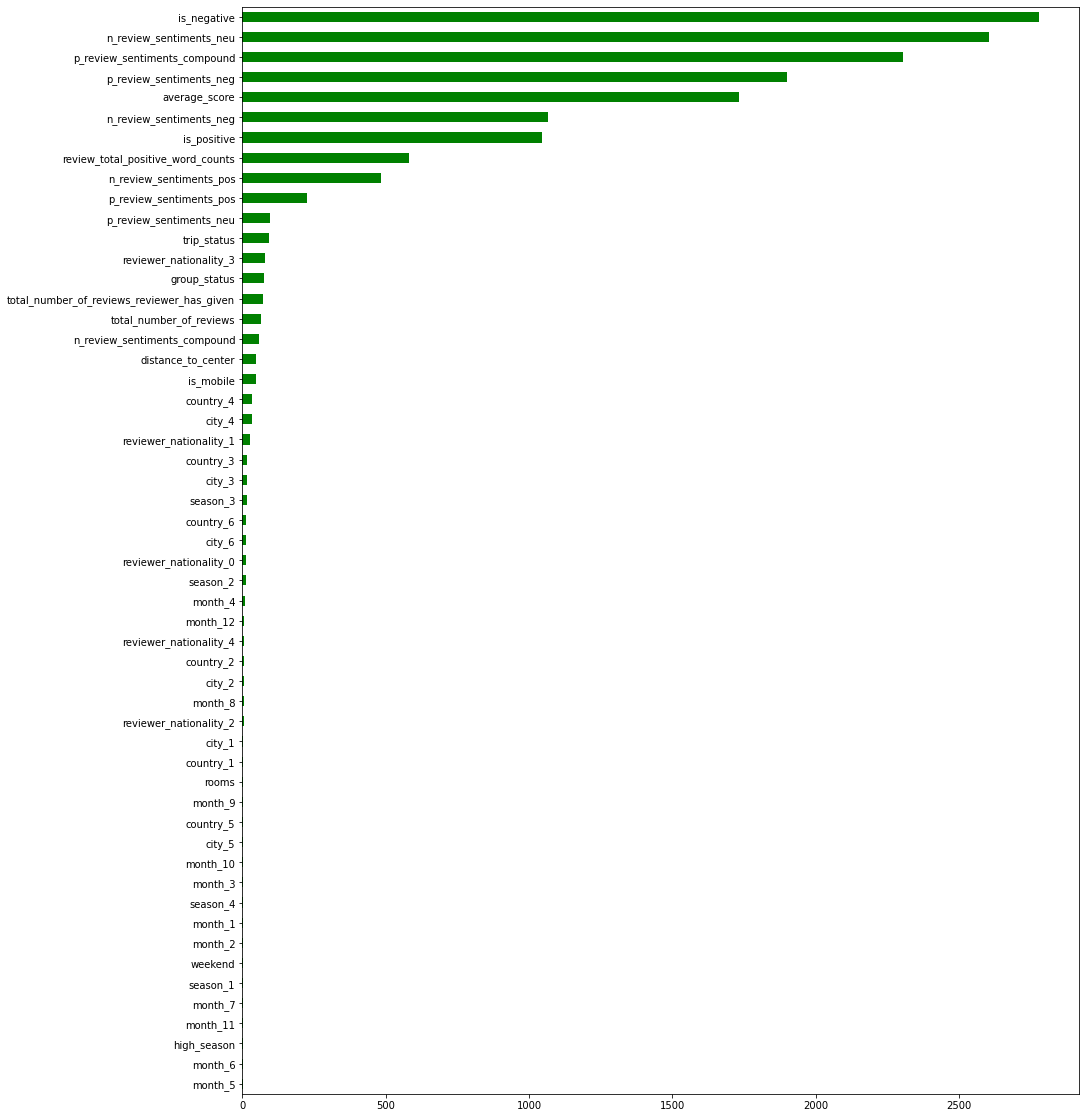

In [124]:
# для оценки значимости непрерывных переменных будем использовать дисперсионным анализом ANOVA
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

In [125]:
cols_to_delete_2 = ['city_1', 'country_1', 'rooms', 'month_9', 'city_5', 'country_5', 'month_10', 'month_3', 'season_4',
                    'month_1', 'month_2', 'weekend', 'season_1', 'month_7', 'month_11', 'high_season', 'month_6', 'month_5']

In [126]:
data.drop(cols_to_delete_2, axis = 1, inplace=True)

In [127]:
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515738, 38)


## Удаление дубликатов

In [128]:
# отфильтруем тренировочный датасет
mask = data['sample'] == 1
print(f'Число записей: {data[mask].shape[0]}')

# список столбцов для поиска совпадений
dupl_columns = list(data[mask].columns)

# маска дубликатов
mask_d = data[mask].duplicated(subset=dupl_columns)

data_duplicates = data[mask][mask_d]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

# Удаление дубликатов по индексу
data.drop(data_duplicates.index, inplace=True)

Число записей: 386803
Число найденных дубликатов: 411


In [129]:
print(f'Размерность таблицы: {data.shape}')

Размерность таблицы: (515327, 38)


## Обучение модели и получение предсказания (Model Building)

In [130]:
# проверка на наличие нечисловых признаков
obj_cols_1 = list(data.select_dtypes('object').columns)
num_cols_1 = list(data.select_dtypes(['int64','float64']).columns)

print(len(obj_cols_1), len(num_cols_1))

0 38


In [131]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

In [132]:
y = train_data.reviewer_score.values            
X = train_data.drop(['reviewer_score'], axis=1)

In [133]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [134]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 37), (386392, 37), (386392, 36), (309113, 36), (77279, 36))

In [135]:
# Создаём модель 
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [136]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.7s finished


In [137]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', round(metrics.mean_absolute_error(y_test, y_pred), 4))

def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 4))

MAE: 0.8651
MAPE: 12.3038


In [138]:
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1230384262942171


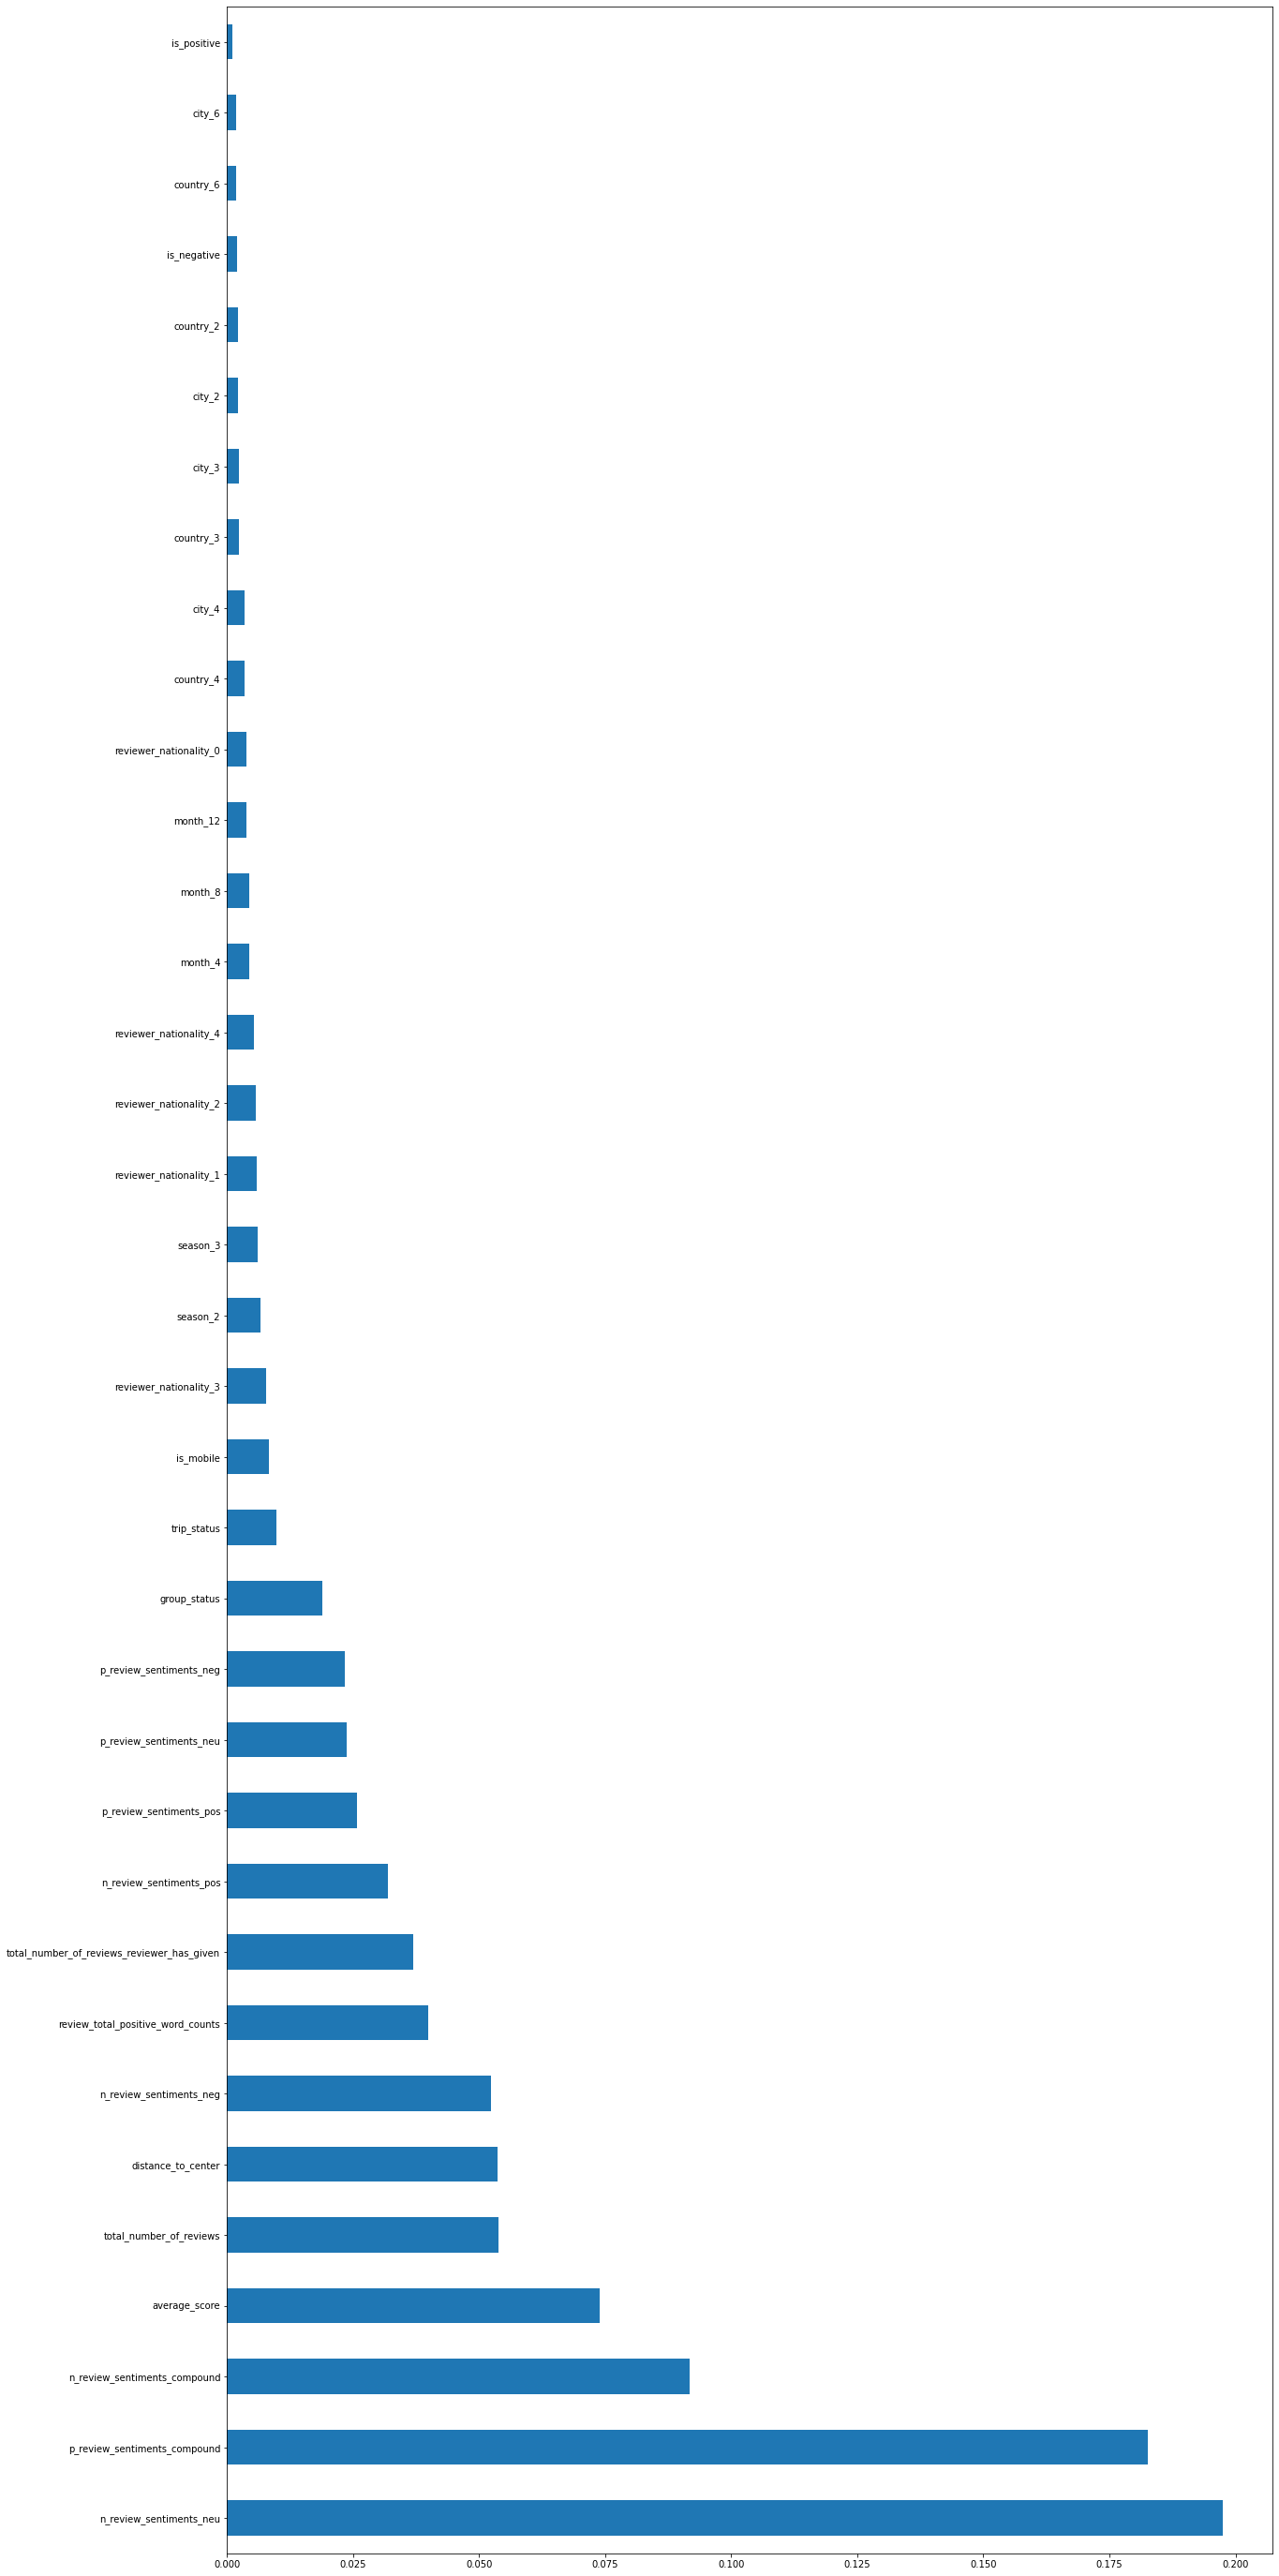

In [139]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (20,50)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(len(feat_importances)).plot(kind='barh');

In [140]:
test_data.sample(10)

,reviewer_score,average_score,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,distance_to_center,is_negative,is_positive,n_review_sentiments_neg,n_review_sentiments_neu,...,month_4,month_8,month_12,season_2,season_3,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
43872,0.0,0.571429,-0.291191,2.823529,0.571429,-0.150425,0.0,0.0,-0.002,0.178409,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2693,0.0,-1.857143,2.835237,-0.529412,0.142857,1.827328,0.0,-1.0,-0.131,-0.546591,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
36993,0.0,-1.000000,1.796493,2.294118,0.000000,0.791592,0.0,0.0,-0.021,0.200000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
93112,0.0,1.142857,-0.542822,8.764706,0.428571,-0.470976,0.0,0.0,-0.131,0.325000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18758,0.0,0.428571,-0.351958,0.588235,3.714286,-0.538582,0.0,0.0,0.046,-0.107955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15037,0.0,1.285714,-0.490620,-0.058824,4.857143,-0.412480,-1.0,0.0,0.869,-0.811364,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
24892,0.0,0.571429,-0.433116,0.411765,2.571429,-0.521331,-1.0,0.0,0.869,-0.811364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
75837,0.0,-0.428571,-0.204731,-0.529412,-0.142857,-0.404753,0.0,0.0,0.009,0.138636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
94946,0.0,0.142857,-0.799755,0.176471,0.000000,-0.164762,0.0,0.0,-0.026,0.205682,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
88599,0.0,1.142857,-0.160685,-0.117647,0.000000,-0.466859,-1.0,0.0,0.869,-0.811364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [142]:
submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [143]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.3s finished


In [144]:
predict_submission

array([8.461, 7.297, 7.976, ..., 7.962, 9.577, 6.857])

In [145]:
submission['reviewer_score'] = predict_submission
# submission.to_csv('submission.csv', index=False)
submission.head(10)

,reviewer_score,id
0,8.461,488440
1,7.297,274649
2,7.976,374688
3,9.816,404352
4,9.306,451596
5,8.764,302161
6,7.336,317079
7,7.737,13963
8,8.521,159785
9,7.651,195089
